In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow.keras as keras

from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
# base_dir = '/content/drive/My Drive/Colab Notebooks/facial-expression/input'
base_dir = '/'
print(os.listdir(base_dir))

C:\Users\iiats\Anaconda3\envs\Python36-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\iiats\Anaconda3\envs\Python36-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\iiats\Anaconda3\envs\Python36-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\iiats\Anaconda3\envs\Python36-gpu\lib\site-

['$Recycle.Bin', '$SysReset', 'devlist.txt', 'Documents and Settings', 'eSupport', 'Finish.log', 'hiberfil.sys', 'images', 'Intel', 'MinGW', 'OneDriveTemp', 'pagefile.sys', 'PerfLogs', 'Program Files', 'Program Files (x86)', 'ProgramData', 'Recovery', 'swapfile.sys', 'System Volume Information', 'Users', 'Windows']


In [2]:
# Pythonバージョン確認
import sys
print(sys.version)

3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]


In [3]:
# Kerasバージョン確認
print(keras.__version__)

2.2.4-tf


In [4]:
# Tensorflowバージョン確認
import tensorflow as tf
print(tf.__version__)

1.14.0


In [5]:
# Device 情報
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17037298108896368965,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3071698534
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2638953916183745463
 physical_device_desc: "device: 0, name: GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:02:00.0, compute capability: 7.5"]

In [6]:
# # googleDriveを使えるようにする（マウントする）コード
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
#data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/facial-expression/fer2013_4.csv').drop('Unnamed: 0', axis=1)

In [8]:
data = pd.read_csv('fer2013_4.csv').drop('Unnamed: 0', axis=1)

In [9]:
data.shape

(31885, 3)

In [10]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,0,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,0,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,0,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [11]:
data.emotion.value_counts()

0    22896
1     8989
Name: emotion, dtype: int64

In [12]:
data_train = data[data['Usage'] == 'Training'].copy()
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()
# formatは、{}の中にformatの引数が入れられる
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (25538, 3), 
validation shape: (3174, 3), 
test shape: (3173, 3)


In [13]:
num_classes = 2  # 識別させるクラスの数
width, height = 48, 48   # 画像のサイズ
num_epochs = 100  # 「学習データをN個のサブセットに分け、それぞれ１回ずつ、学習データ全体で計N回学習させる」ということを何回繰り返し学習させるか？
batch_size = 64  # 学習データをいくつのサブセットに分けるか？例：1000の学習データを、200データの5サブセットに分ける場合、今回の学習データに対する学習は５回行われる
num_features = 64 

In [14]:
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (25538, 48, 48, 1)
val _X shape: {},  val _Y shape: (3174, 48, 48, 1)
test _X shape: {},  test _Y shape: (3173, 48, 48, 1)


In [15]:
train_Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [16]:
train_X[1]

array([[[0.5921569 ],
        [0.5882353 ],
        [0.5764706 ],
        ...,
        [0.5058824 ],
        [0.54901963],
        [0.47058824]],

       [[0.5921569 ],
        [0.58431375],
        [0.58431375],
        ...,
        [0.47843137],
        [0.5529412 ],
        [0.5372549 ]],

       [[0.5921569 ],
        [0.5921569 ],
        [0.6117647 ],
        ...,
        [0.42745098],
        [0.48235294],
        [0.57254905]],

       ...,

       [[0.7372549 ],
        [0.7372549 ],
        [0.4745098 ],
        ...,
        [0.7254902 ],
        [0.7254902 ],
        [0.7294118 ]],

       [[0.7372549 ],
        [0.73333335],
        [0.76862746],
        ...,
        [0.7294118 ],
        [0.7137255 ],
        [0.73333335]],

       [[0.7294118 ],
        [0.72156864],
        [0.7254902 ],
        ...,
        [0.75686276],
        [0.7176471 ],
        [0.72156864]]], dtype=float32)

## モデル作成

In [17]:
model = Sequential()

In [18]:
## 畳み込み層
model.add(Conv2D(
        2*2*num_features, 
        kernel_size=(3,3), 
        input_shape=(width, height, 1)
))
model.add(BatchNormalization())
## 活性化関数
model.add(Activation('relu'))
## 畳み込み層
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
## 活性化関数
model.add(Activation('relu'))
## プーリング層
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

In [19]:
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [20]:
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [21]:
model.add(Flatten())

In [22]:
## dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

In [23]:
model.add(Dense(num_classes, activation='softmax'))

In [24]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
    metrics=['accuracy']
)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 256)       0         
_________

In [25]:
# データ水増し
data_generator = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=1,
    horizontal_flip=True
)

In [26]:
# early stopping
es = EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='min',
    restore_best_weights=True
)

In [27]:
# ベストモデルのみ保存する
# https://qiita.com/tom_eng_ltd/items/7ae0814c2d133431c84a
from keras.callbacks import ModelCheckpoint

modelCheckpoint = ModelCheckpoint(filepath = 'model.h5',
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True, # ベストのモデルのみ保存する
                                  save_weights_only=False,
                                  mode='min',
                                  period=1)

In [28]:

history = model.fit_generator(
    data_generator.flow(train_X, train_Y, batch_size),
    steps_per_epoch=len(train_X)/batch_size,
    epochs=num_epochs,
    verbose=1,
    callbacks=[es, modelCheckpoint], # 書き換え
    validation_data=(val_X, val_Y)
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
400/399 [==============================] - 105s 262ms/step - loss: 0.6069 - acc: 0.7058 - val_loss: 0.5748 - val_acc: 0.7187

Epoch 00001: val_loss improved from inf to 0.57480, saving model to model.h5
Epoch 2/100
400/399 [==============================] - 97s 242ms/step - loss: 0.5909 - acc: 0.7143 - val_loss: 0.5837 - val_acc: 0.7105

Epoch 00002: val_loss did not improve from 0.57480
Epoch 3/100
400/399 [==============================] - 97s 243ms/step - loss: 0.5732 - acc: 0.7213 - val_loss: 0.5287 - val_acc: 0.7476

Epoch 00003: val_loss improved from 0.57480 to 0.52870, saving model to model.h5
Epoch 4/100
400/399 [==============================] - 97s 243ms/step - loss: 0.5348 - acc: 0.7486 - val_loss: 0.4752 - val_acc: 0.8047

Epoch 00004: val_loss improved from 0.52870 to 0.47518, saving model to model.h5
Epoch 5/100
400/399 [==============================] - 97s 243ms/st


Epoch 00040: val_loss did not improve from 0.22042
Epoch 41/100
400/399 [==============================] - 97s 241ms/step - loss: 0.3505 - acc: 0.8487 - val_loss: 0.2225 - val_acc: 0.9175

Epoch 00041: val_loss did not improve from 0.22042
Epoch 42/100
400/399 [==============================] - 97s 241ms/step - loss: 0.3368 - acc: 0.8547 - val_loss: 0.2211 - val_acc: 0.9152

Epoch 00042: val_loss did not improve from 0.22042
Epoch 43/100
400/399 [==============================] - 97s 243ms/step - loss: 0.3334 - acc: 0.8570 - val_loss: 0.2175 - val_acc: 0.9162

Epoch 00043: val_loss improved from 0.22042 to 0.21754, saving model to model.h5
Epoch 44/100
400/399 [==============================] - 97s 243ms/step - loss: 0.3323 - acc: 0.8579 - val_loss: 0.2312 - val_acc: 0.9127

Epoch 00044: val_loss did not improve from 0.21754
Epoch 45/100
400/399 [==============================] - 97s 243ms/step - loss: 0.3289 - acc: 0.8609 - val_loss: 0.2286 - val_acc: 0.9146

Epoch 00045: val_loss di


Epoch 00082: val_loss did not improve from 0.19277
Epoch 83/100
400/399 [==============================] - 96s 241ms/step - loss: 0.2892 - acc: 0.8775 - val_loss: 0.2092 - val_acc: 0.9250

Epoch 00083: val_loss did not improve from 0.19277
Epoch 84/100
400/399 [==============================] - 97s 242ms/step - loss: 0.2929 - acc: 0.8777 - val_loss: 0.2093 - val_acc: 0.9197

Epoch 00084: val_loss did not improve from 0.19277
Epoch 85/100
400/399 [==============================] - 97s 242ms/step - loss: 0.2908 - acc: 0.8761 - val_loss: 0.2048 - val_acc: 0.9253

Epoch 00085: val_loss did not improve from 0.19277
Epoch 86/100
400/399 [==============================] - 97s 243ms/step - loss: 0.3275 - acc: 0.8600 - val_loss: 0.2231 - val_acc: 0.9152

Epoch 00086: val_loss did not improve from 0.19277
Epoch 87/100
400/399 [==============================] - 96s 241ms/step - loss: 0.2976 - acc: 0.8738 - val_loss: 0.2006 - val_acc: 0.9250

Epoch 00087: val_loss did not improve from 0.19277
Epo

In [29]:
# 学習プロセスのプロット用関数

def Learning_Process_Plot(hist):
    acc = hist.history['acc'] # tf2.x: accuracy
    val_acc = hist.history['val_acc'] # tf2.x: val_accuracy
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label='Training acc', ls="-", marker="o")
    plt.plot(epochs, val_acc, label='Validation acc', ls="-", marker="x")
    plt.title('Training and validation accuracy')
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="best")

    plt.figure()

    plt.plot(epochs, loss, label='Training loss', ls="-", marker="o")
    plt.plot(epochs, val_loss, label='Validation loss', ls="-", marker="x")
    plt.title('Training and validation loss')
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(loc="best")

    plt.show()

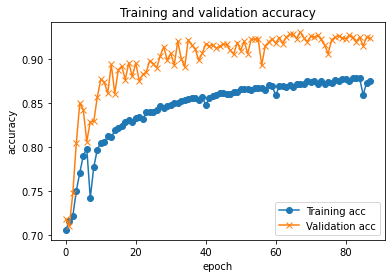

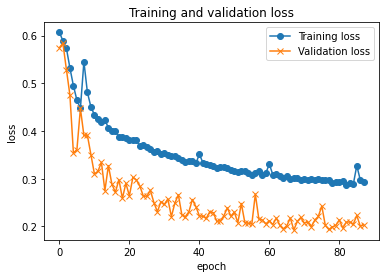

In [30]:
# 学習プロセスのプロット
Learning_Process_Plot(history)

In [31]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.9420


In [32]:
test_true

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [33]:
test_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [34]:
#model.save("drive/My Drive/Colab Notebooks/facial-expression/2020-10-24-MrIi-fer2013_4.h5")

In [35]:
# 保存したモデルをロード
from tensorflow.keras.models import load_model
# saved_model = load_model('/content/drive/My Drive/Colab Notebooks/facial-expression/2020-10-09-MrIi-fer2013_4.h5')
# saved_model2 = load_model('/content/drive/My Drive/Colab Notebooks/facial-expression/2020-10-24-MrIi-fer2013_4.h5')
saved_model = load_model('model.h5')

In [36]:
# 保存したモデルの確認としてテストデータで判別させる
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(saved_model.predict(test_X), axis=1)
print("model ver 1 CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

model ver 1 CNN Model Accuracy on test set: 0.9420


In [37]:
# # 保存したモデルの確認としてテストデータで判別させる
# test_true2 = np.argmax(test_Y, axis=1)
# test_pred2 = np.argmax(saved_model2.predict(test_X), axis=1)
# print("model ver 2CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true2, test_pred2)))

In [38]:
print(test_true)

[0 0 0 ... 0 1 0]


In [39]:
# print(test_true2)

In [40]:
#u_true, counts_true = np.unique(test_true, return_counts=True)
#print(u_true)

[0 1]


In [41]:
#print(counts_true)

[2294  879]


In [42]:
#u_pred, counts_pred = np.unique(test_pred, return_counts=True)
#print(u_pred)

[0 1]


In [43]:
#print(counts_pred)

[2300  873]


In [44]:
"""print(test_true)
test_true_bad  = np.count_nonzero(test_true == 0)
test_true_sad  = np.count_nonzero(test_true == 1)
test_true_happy  = np.count_nonzero(test_true == 2)
test_true_surprise  = np.count_nonzero(test_true == 3)
print(test_true_bad)
"""

[0 0 0 ... 0 1 0]
2294


In [45]:
"""print(test_pred)
test_pred_bad  = np.count_nonzero(test_pred == 0)
test_pred_sad  = np.count_nonzero(test_pred == 1)
test_pred_happy  = np.count_nonzero(test_pred == 2)
test_pred_surprise  = np.count_nonzero(test_pred == 3)
print(test_pred_bad)"""

[0 0 0 ... 0 1 0]
2300


In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_true, test_pred)

Confusion Matrix
------------------
[[2205   89]
 [  95  784]]
------------------


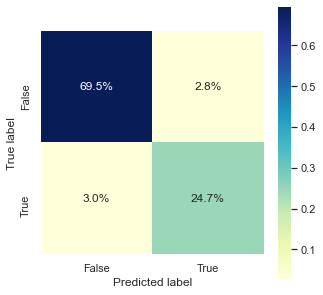

In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set()

cm_rate = cm / cm.sum()

# 混合行列を描画する。
def print_confusion_matrix(confusion_matrix, class_names):
    fig = plt.figure(figsize=(5, 5))
    heatmap = sns.heatmap(
        confusion_matrix, xticklabels=class_names, yticklabels=class_names,
        annot=True, fmt='.1%', cbar=True, square=True, cmap='YlGnBu')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

labels = ["False","True"]

print("Confusion Matrix")
print("------------------")
print(cm)
print("------------------")

print_confusion_matrix(cm_rate, labels)

# 縦軸の表示がおかしいのは matplotlib 3.1.1 のバグ
# https://teratail.com/questions/205195

In [48]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(test_true2, test_pred2)

In [49]:
# model1
target_names=["bad", "happy"]
print(classification_report(test_true, test_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

         bad     0.9587    0.9612    0.9599      2294
       happy     0.8981    0.8919    0.8950       879

    accuracy                         0.9420      3173
   macro avg     0.9284    0.9266    0.9275      3173
weighted avg     0.9419    0.9420    0.9419      3173



In [50]:
# # model2
# target_names=["bad", "happy"]
# print(classification_report(test_true2, test_pred2, target_names=target_names))

In [51]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(test_true, test_pred)

In [52]:
print(fpr)

[0.         0.03879686 1.        ]


In [53]:
print(tpr)

[0.         0.89192264 1.        ]


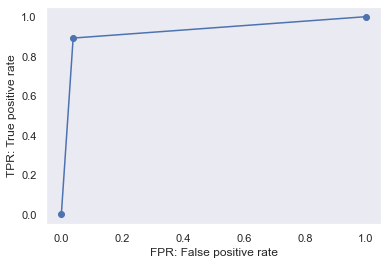

In [54]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
# plt.savefig('data/dst/sklearn_roc_curve.png')

In [55]:
from sklearn.metrics import roc_auc_score
import numpy as np

print(roc_auc_score(test_true, test_pred))

0.926562888992703


In [56]:
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score,f1_score
# print('confusion matrix = \n', confusion_matrix(y_true = test_true2, y_pred = test_pred2))
# print('accuracy = ',accuracy_score(y_true = test_true2 , y_pred = test_pred2))
# print('precision = ',precision_score(y_true = test_true2 , y_pred = test_pred2))
# print('recall = ',recall_score(y_true = test_true2 , y_pred = test_pred2))
# print('f1 score = ',f1_score(y_true = test_true2 , y_pred = test_pred2))
 

In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score,f1_score
print('confusion matrix = \n', confusion_matrix(y_true = test_true, y_pred = test_pred))
print('accuracy = ',accuracy_score(y_true = test_true , y_pred = test_pred))
print('precision = ',precision_score(y_true = test_true , y_pred = test_pred))
print('recall = ',recall_score(y_true = test_true , y_pred = test_pred))
print('f1 score = ',f1_score(y_true = test_true , y_pred = test_pred))
 

confusion matrix = 
 [[2205   89]
 [  95  784]]
accuracy =  0.9420107154112827
precision =  0.8980526918671249
recall =  0.8919226393629124
f1 score =  0.8949771689497716
